In [ ]:

import pandas as pd 
import time
import csv
import matplotlib.pyplot as plt
import numpy as np 
import pickle 
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=20,10 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')
import time
from keras.layers.recurrent import LSTM
from keras.layers.core import Activation, Dense, Dropout
from keras.models import Sequential, load_model
from numpy.random import seed
seed(1234)  # seed random numbers for Keras
import tensorflow
tensorflow.random.set_seed(2)  # seed random numbers for Tensorflow backend

ModuleNotFoundError: ignored

In [ ]:
pip install lux

     |████████████████████████████████| 358kB 5.6MB/s 
     |████████████████████████████████| 40kB 3.5MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
  Using cached https://files.pythonhosted.org/packages/71/46/abcf7f8a03b17f840a99020f8467344aa998eb5b46f22b66830c7119fed6/pulsar-2.0.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a1/35/b22524d6b9cacfb4c5eff413a069bbc17c6ea628e54da5c6c989998ced5f/multidict-5.1.0-cp36-cp36m-manylinux2014_x86_64.whl
  Created wheel for pulsar-odm: filename=pulsar_odm-0.7.0-cp36-none-any.whl size=16987 sha256=7fdf87a3143b819e4691d70e5c2177e347d853a4a5420a75019b57bc7a47ff34
  Stored in directory: /root/.cache/pip/wheels/fe/f1/d2/8869522a83206259759b0ea742c9d94528fa250de84c3d4db9
Successfully built pulsar-odm


In [ ]:
df = pd.read_csv('household_power_consumption.txt', sep=";", header=None)
df.head()

,0,1,2,3,4,5,6,7,8
0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
1,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
2,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
3,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000
4,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.000


In [ ]:
def load_data(dataset_path, sequence_length=60, prediction_steps=5,ratio_of_data=1.0):
  # 2075259 is the total number of measurements
  # from Dec 2006 to Nov 2010
  max_values = ratio_of_data * 2075259
  # Load data from file
  with open(dataset_path) as file:
    data_file = csv.reader(file, delimiter=";") 
    power_consumption = []
    number_of_values = 0
    for line in data_file:
        try:
          power_consumption.append(float(line[2]))
          print(line[2])
          number_of_values += 1
        except ValueError:
             pass
        # limit data to be considered by
        # model according to max_values
        if number_of_values >= max_values:
             break
  print('Loaded data from csv.')
  print(power_consumption)
  windowed_data = []
  # Format data into rolling window sequences
  # for e.g: index=0 => 123, index=1 => 234 etc.
  for index in range(len(power_consumption) - sequence_length):
      windowed_data.append(power_consumption[index: index + sequence_length])
  # shape (number of samples, sequence length)
  windowed_data = np.array(windowed_data)
  # Center data
  data_mean = windowed_data.mean()
  windowed_data -= data_mean
  print('Center data so mean is zero(subtract each data point by mean of value: ',data_mean, ')')
  print('Data : ', windowed_data.shape)
  # Split data into training and testing sets
  train_set_ratio = 0.9
  row = int(round(train_set_ratio * windowed_data.shape[0]))
  train = windowed_data[:row, :]
  # remove last prediction_steps from train set
  x_train = train[:, :-prediction_steps]
  # take last prediction_steps from train set
  y_train = train[:, -prediction_steps:]
  x_test = windowed_data[row:, :-prediction_steps]
  # take last prediction_steps from test set
  y_test = windowed_data[row:, -prediction_steps:]
  x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
  x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))
  print(power_consumption[1])
  return [x_train, y_train, x_test, y_test, data_mean]

In [ ]:
def
 build_model(prediction_steps):
  model = Sequential()
  layers = [1, 75, 100, prediction_steps]
  model.add(LSTM(layers[1],input_shape=(None, layers[0]), return_sequences=True)) # add first layer
  model.add(Dropout(0.2)) # add dropout for first layer
  model.add(LSTM(layers[2],return_sequences=False)) # add second layer
  model.add(Dropout(0.2)) # add dropout for second layer
  model.add(Dense(layers[3])) # add output layer
  model.add(Activation('linear')) # output layer
  start = time.time()
  model.compile(loss="mse", optimizer="rmsprop")
  print('Compilation Time : ', time.time() - start)
  return model


In [ ]:
# plot results
def plot_predictions(result_mean, prediction_steps, predicted, y_test, global_start_time):
    try:
        test_hours_to_plot = 2
        t0 = 20  # time to start plot of predictions
        skip = 15  # skip prediction plots by specified minutes
        print('Plotting predictions...')
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(y_test[:test_hours_to_plot * 60, 0] + result_mean, label='Raw data')  # plot actual test series

        # plot predicted values from t0 to t0+prediction_steps
        plt.plot(np.arange(t0 - 1, t0 + prediction_steps),
                 np.insert(predicted[t0, :], 0, y_test[t0 - 1, 0]) + result_mean,
                 color='red', label='t+{0} evolution of predictions'.format(prediction_steps))
        for i in range(t0, test_hours_to_plot * 60, skip):
            t0 += skip
            if t0 + prediction_steps > test_hours_to_plot * 60:  # check plot does not exceed boundary
                break
            plt.plot(np.arange(t0 - 1, t0 + prediction_steps),
                     np.insert(predicted[t0, :], 0, y_test[t0 - 1, 0]) + result_mean, color='red')

        # plot predicted value of t+prediction_steps as series
        plt.plot(predicted[:test_hours_to_plot * 60, prediction_steps - 1] + result_mean,
                 label='t+{0} prediction series'.format(prediction_steps))

        plt.legend(loc='lower left')
        plt.ylabel('Actual Power in kilowatt')
        plt.xlabel('Time in minutes')
        plt.title('Predictions for first {0} minutes in test set'.format(test_hours_to_plot * 60))
        plt.show()
    except Exception as e:
        print(str(e))
    print('Duration of training (s) : ', time.time() - global_start_time)

    return None

In [ ]:
def run_lstm(model, sequence_length, prediction_steps):
  data = None
  global_start_time = time.time()
  epochs = 1
  ratio_of_data = 1 # ratio of data to use from 2+ million data points
  path_to_dataset = '/content/household_power_consumption.txt'
  if data is None:
    print('Loading data... ')
    x_train, y_train, x_test, y_test, result_mean =load_data(path_to_dataset, sequence_length,prediction_steps, ratio_of_data)
  else:
    x_train, y_train, x_test, y_test = data
  print('\nData Loaded. Compiling...\n')
  model.fit(x_train, y_train, batch_size=128, epochs=epochs,validation_split=0.05)
  predicted = model.predict(x_test)
  # predicted = np.reshape(predicted, (predicted.size,))
  model.save('LSTM_power_consumption_model.h5') # save LSTM model
  plot_predictions(result_mean, prediction_steps, predicted,y_test, global_start_time)
  return None

Compilation Time :  0.00691986083984375
Loading data... 
Loaded data from csv.
Center data so mean is zero(subtract each data point by mean of value:  1.091607820345784 )
Data :  (2049270, 10)

Data Loaded. Compiling...

13689/13689 [==============================] - 315s 23ms/step - loss: 0.1916 - val_loss: 0.1599
Plotting predictions...


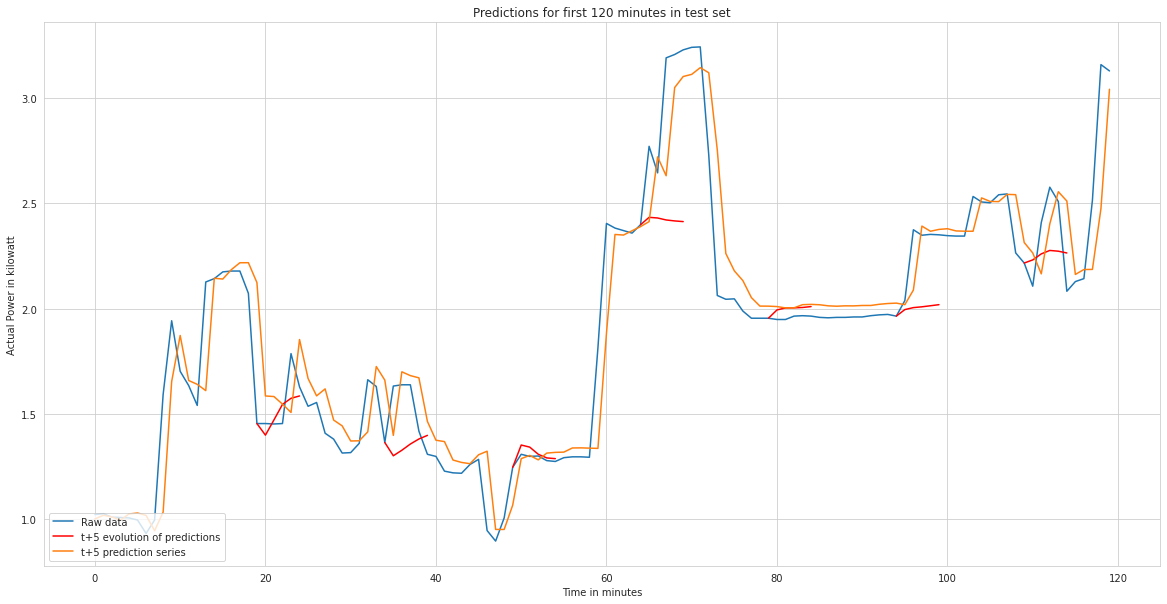

Duration of training (s) :  342.4739410877228


In [ ]:
sequence_length = 10 # number of past minutes of data for model toconsider
prediction_steps = 5 # number of future minutes of data for modelto predict
model = build_model(prediction_steps)
run_lstm(model, sequence_length, prediction_steps)

In [ ]:
len(h[1])

1844298